<a href="https://colab.research.google.com/github/Kubenew/hrl-minimal/blob/main/Copy_of_Agents_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0 score 0.5474565544631332
200 score 0.2368648661054467
400 score 0.4143017776636406
600 score 0.16858058604225515
800 score 0.1933922410119558
1000 score 0.1593999970612349
1200 score 0.22357941396214304
1400 score 0.3838438488168176
1600 score 0.29121231696149336
1800 score 0.3428447871038807
2000 score 0.28530090684804593
2200 score 0.29724213992542353
2400 score 0.3528161104656173
2600 score 0.2825483733186848
2800 score 0.17267841981621312
3000 score 0.1797831619185456
3200 score 0.23996283807786004
3400 score 0.23998115676779685
3600 score 0.3399288370871616
3800 score 0.2399267991320568


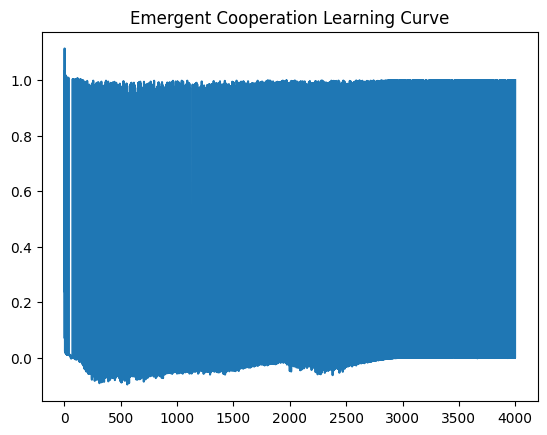

In [ ]:
# ==========================================================
# Proto-AGI Multi-Agent Communication Playground (GPU)
# Emergent Language via Shared World Model + Agreement Reward
# ==========================================================

!pip -q install torch numpy matplotlib

import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, random, matplotlib.pyplot as plt
device="cuda" if torch.cuda.is_available() else "cpu"

# ==========================================================
# ENVIRONMENT — cooperative push world
# agents must push object to target but cannot alone
# ==========================================================

class PushWorld:
    def __init__(self,size=7,n_agents=3):
        self.size=size
        self.n=n_agents
        self.reset()

    def reset(self):
        self.obj=np.array([3,3])
        self.goal=np.array([6,6])
        self.pos=np.random.randint(0,self.size,(self.n,2))
        return self.obs()

    def obs(self):
        o=[]
        for i in range(self.n):
            o.append(np.concatenate([self.pos[i],self.obj,self.goal])/self.size)
        return np.array(o,dtype=np.float32)

    def step(self,actions):
        moves=[[0,0],[1,0],[-1,0],[0,1],[0,-1]]
        for i,a in enumerate(actions):
            self.pos[i]=np.clip(self.pos[i]+moves[a],0,self.size-1)

        # object moves only if 2+ agents near it
        near=[np.linalg.norm(self.pos[i]-self.obj)<1.5 for i in range(self.n)]
        if sum(near)>=2:
            direction=np.sign(self.goal-self.obj)
            self.obj+=direction

        done=np.all(self.obj==self.goal)
        reward=1.0 if done else 0.0
        return self.obs(),reward,done,{}

# ==========================================================
# WORLD MODEL
# ==========================================================

LATENT=32
MSG=12

class WorldModel(nn.Module):
    def __init__(self,obs=6):
        super().__init__()
        self.enc=nn.Linear(obs,LATENT)
        self.rnn=nn.GRUCell(LATENT+5+MSG,LATENT)
        self.pred=nn.Linear(LATENT,LATENT)

    def forward(self,z,obs,a,msg):
        e=torch.tanh(self.enc(obs))
        x=torch.cat([e,F.one_hot(a,5).float(),msg],-1)
        z=self.rnn(x,z)
        z_pred=self.pred(z)
        return z,z_pred

# ==========================================================
# AGENT
# ==========================================================

class Agent(nn.Module):
    def __init__(self):
        super().__init__()
        self.policy=nn.Linear(LATENT+MSG,5)
        self.msg=nn.Linear(LATENT,MSG)

    def act(self,z,received):
        x=torch.cat([z,received],-1)
        logits=self.policy(x)
        a=torch.distributions.Categorical(logits=logits).sample()
        msg=torch.tanh(self.msg(z))
        return a,msg

# ==========================================================
# AGREEMENT REWARD
# agents rewarded when their predictions match
# ==========================================================

def agreement_bonus(predictions):
    stack=torch.stack(predictions)
    variance=torch.var(stack,dim=0).mean()
    return -variance

# ==========================================================
# TRAINING
# ==========================================================

env=PushWorld()
agents=[Agent().to(device) for _ in range(env.n)]
wm=WorldModel().to(device)

opt=torch.optim.Adam(list(wm.parameters())+
                     [p for a in agents for p in a.parameters()],lr=2e-4)

EPISODES=4000
history=[]

for ep in range(EPISODES):

    obs=torch.tensor(env.reset(),device=device)
    z=torch.zeros(env.n,LATENT,device=device)
    msgs=torch.zeros(env.n,MSG,device=device)

    total=0

    for t in range(40):

        # communication — average received messages
        received=msgs.mean(0).repeat(env.n,1)

        acts=[]
        new_msgs=[]
        for i,a in enumerate(agents):
            act,msg=a.act(z[i],received[i])
            acts.append(act)
            new_msgs.append(msg)

        acts=torch.stack(acts)
        new_msgs=torch.stack(new_msgs)

        obs2,r,done,_=env.step(acts.cpu().numpy())
        obs2=torch.tensor(obs2,device=device)

        # world model prediction
        preds=[]
        z_next=[]
        for i in range(env.n):
            zn,p=wm(z[i],obs[i],acts[i],received[i])
            z_next.append(zn)
            preds.append(p)

        z_next=torch.stack(z_next)

        # curiosity reward
        curiosity=F.mse_loss(torch.stack(preds),z_next.detach())

        # agreement reward
        agree=agreement_bonus(preds)

        reward=r + 0.2*curiosity.item() + 0.3*agree.item()

        loss=F.mse_loss(torch.stack(preds),z_next.detach()) - agree*0.5

        opt.zero_grad()
        loss.backward()
        opt.step()

        z=z_next.detach()
        msgs=new_msgs.detach()
        obs=obs2

        total+=reward
        if done: break

    history.append(total)

    if ep%200==0:
        print(ep,"score",np.mean(history[-50:]))

# ==========================================================
# VISUALIZE LEARNING
# ==========================================================

plt.plot(history)
plt.title("Emergent Cooperation Learning Curve")
plt.show()
